In [1]:
# A simple PyTorch autoencoder to encode images in space.

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn

/h/299/coopermj/.conda/envs/deephit_test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
import os, sys
import re
sys.path.append('../data/')

def sort_key(x):
    return int(re.sub('[^0-9]','', x))

class videoFrameDataset(Dataset):
    def __init__(self, dir, image_size):
        self.dir = dir
        self.imgs = [_ for _ in os.listdir(dir) if _.endswith("endo.png")] # List of image names in the directory
        self.imgs = sorted(self.imgs, key=sort_key)
        self.transform = T.Compose([
        T.Resize(image_size),
        T.ToTensor()])

    def __len__(self):
        return len(self.imgs)

    def get_path(self, idx):
        return self.dir + self.imgs[idx]

    def __getitem__(self, idx):
        img = Image.open(self.dir + "/" + self.imgs[idx])
        return self.transform(img)

In [49]:
ds = videoFrameDataset("../data/archive/video01_lueder/", (200, 200))

In [50]:
len(ds)

1280

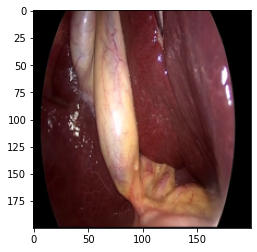

In [5]:
import matplotlib.pyplot as plt

plt.imshow(ds.__getitem__(0).permute(1, 2, 0))

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 32, 2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=4),
        #     nn.Conv2d(32, 32, 4),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=4),
        #     nn.Conv2d(32, 1, 2),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Flatten(),
        #     nn.Linear(25, 25)
        # )
        # self.decoder = nn.Sequential(
        #     nn.Linear(25, 25),
        #     nn.Unflatten(1, (1, 5, 5)),
        #     nn.ConvTranspose2d(1, 32, 15),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 32, 179),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 3, 4),
        # )
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 8),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            nn.Conv2d(32, 1, 8),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            nn.Flatten(),
            nn.Linear(100, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 100),
            nn.Unflatten(1, (1, 10, 10)),
            nn.ConvTranspose2d(1, 32, 182),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 10),
        )
        # self.encoder = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(120000, 240000),
        #     nn.ReLU(),
        #     nn.Linear(240000, 512000),
        #     nn.ReLU(),
        #     nn.Linear(512000, 50),
        # )
        # self.decoder = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(50, 512000),
        #     nn.ReLU(),
        #     nn.Linear(512000, 240000),
        #     nn.ReLU(),
        #     nn.Linear(240000, 120000),
        #     nn.Unflatten(1, (3, 200, 200))
        # )

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


In [8]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

network = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataloader = DataLoader(ds, batch_size=100, shuffle=True)

epochs = 10
for epoch in tqdm(range(epochs)):
    total_loss = 0
    print(f"Epoch: {epoch}")
    for img_batch in tqdm(dataloader):
        img_batch = img_batch.cuda()
        latent = network.encoder(img_batch)
        output = network.decoder(latent)
        # Add a sparsity term with some limit -- encourage variance to be 1 in the average
        if (l_term2 := torch.log(torch.mean(torch.var(network.encoder(img_batch), axis=0)))) > 0:
            l_term2 = 0
        loss = criterion(output, img_batch) - l_term2
        # print(img_batch)
        # print(network.encoder(img_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    print('epoch [{}/{}], loss:{:.4f}'
        .format(epoch+1, epochs, total_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0


 10%|█         | 1/10 [00:45<06:50, 45.63s/it]

epoch [1/10], loss:22.3616
Epoch: 1


 20%|██        | 2/10 [01:31<06:04, 45.59s/it]

epoch [2/10], loss:0.3246
Epoch: 2


 30%|███       | 3/10 [02:17<05:21, 45.99s/it]

epoch [3/10], loss:0.2253
Epoch: 3


 40%|████      | 4/10 [03:02<04:33, 45.52s/it]

epoch [4/10], loss:0.1856
Epoch: 4


 50%|█████     | 5/10 [03:49<03:49, 45.97s/it]

epoch [5/10], loss:0.1643
Epoch: 5


 60%|██████    | 6/10 [04:34<03:03, 45.82s/it]

epoch [6/10], loss:0.1524
Epoch: 6


 70%|███████   | 7/10 [05:25<02:22, 47.51s/it]

epoch [7/10], loss:0.1418
Epoch: 7


 80%|████████  | 8/10 [06:11<01:33, 46.97s/it]

epoch [8/10], loss:0.1355
Epoch: 8


 90%|█████████ | 9/10 [06:56<00:46, 46.38s/it]

epoch [9/10], loss:0.1279
Epoch: 9


100%|██████████| 10/10 [07:42<00:00, 46.29s/it]

epoch [10/10], loss:0.1202


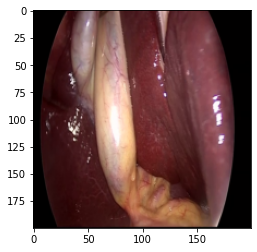

In [22]:
plt.imshow(ds.__getitem__(1).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([  2.7634, -12.7436,  -0.1539, -15.7349,  -9.0800, -28.6746,  -1.3906,
         -5.0654,  -4.5247,  14.8802,  -3.6250,  -9.9009,  13.9194, -17.6300,
         -9.2192,   4.6499,  -5.6192,  -0.0812,   0.3763,   6.8192])


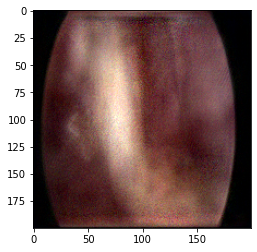

In [9]:
in_img = ds.__getitem__(1).unsqueeze(0).cuda()
plt.imshow(
    network(in_img).detach().cpu().squeeze().permute(1, 2, 0))
print(network.encoder(in_img).detach().cpu().squeeze())

In [51]:
# Plot frame locations in the latent space
import matplotlib
import numpy as np
latent_locs = []
colours = []
cmap = matplotlib.cm.get_cmap('Reds')

# prior_img = None
for i, img in tqdm(enumerate(ds)):
    # if i > 0:
    #     print((img == prior_img).all())
    #     prior_img = img
    # else:
    #     prior_img = img
    latent_locs.append(network.encoder(img.unsqueeze(0).cuda()).detach().cpu().numpy())
    colours.append(cmap(float(i) / len(ds)))

latent_locs = np.array(latent_locs).squeeze()
print(latent_locs)




1280it [00:39, 32.28it/s]

[[  0.96249235 -11.63957      0.44052827 ...   1.7192719    3.9904065
    9.219481  ]
 [  0.64657384 -11.475018     0.6781312  ...   1.7891839    3.7741413
    9.514771  ]
 [  0.37141803 -11.454417     0.8642874  ...   1.7963357    3.626146
    9.740579  ]
 ...
 [  4.6198425  -18.449787     1.7372112  ...  -2.0881855   -4.7679896
    7.719209  ]
 [  4.827701   -18.679848     1.9419072  ...  -2.5141087   -4.5427217
    7.3863177 ]
 [  4.886647   -18.765688     1.872647   ...  -2.7777097   -4.218676
    6.981763  ]]


/h/299/coopermj/.conda/envs/deephit_test/lib/python3.8/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


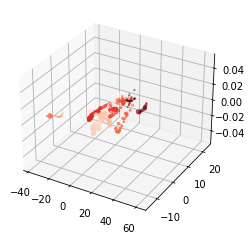

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=0)
pca_obj = pca.fit_transform(latent_locs)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.rcParams['figure.figsize'] = [8, 6]
plt.scatter(pca_obj[:,0], pca_obj[:,1], pca_obj[:,2], c=colours, marker="o")
plt.show()

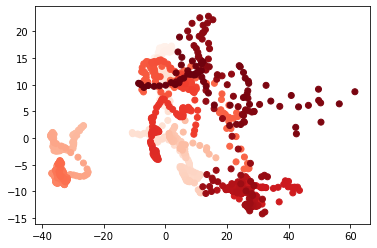

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
pca_obj = pca.fit_transform(latent_locs)

fig = plt.figure()
ax = fig.add_subplot()

plt.scatter(pca_obj[:,0], pca_obj[:,1], c=colours, marker="o")
plt.show()

In [54]:
# Also try a known encoding scheme -- like a ResNet.
# Oh I'm running into the same silly problems that caused RN in the first place -- CNNs that can't learn the identity function. (ARGH!!)
# Maybe also try a VAE. Then there's ample to discuss in the writeup.

In [55]:
ref = latent_locs[0, :] # The image that we want to observe

In [56]:
distances = np.linalg.norm(latent_locs - ref, axis=-1)

In [57]:
distances

array([ 0.       ,  0.7939158,  1.4468125, ..., 23.664295 , 23.561195 ,
       23.40054  ], dtype=float32)

In [58]:
min_50_distances_idx = np.argpartition(distances, 51)

distances[min_50_distances_idx[:51]]

array([ 0.       , 13.896512 ,  1.4468125,  1.5096643,  1.0740488,
        2.4105723,  2.4842262,  3.3513916,  4.4416213,  4.312179 ,
        3.7161565,  3.791332 ,  3.652959 ,  3.7578518,  4.2617636,
        5.2058353,  6.492531 ,  8.367782 ,  9.405018 ,  9.605031 ,
        9.470747 ,  9.722913 , 11.351035 , 12.816112 , 13.304528 ,
       13.592525 , 13.892243 , 13.366283 , 13.830883 , 13.319806 ,
       11.97656  ,  0.7939158, 10.110559 , 10.108873 , 11.191273 ,
       13.382758 , 13.134377 , 13.282916 , 14.042913 , 14.284251 ,
       14.10945  , 14.499031 , 14.416033 , 14.359317 , 14.047022 ,
       14.246358 , 14.449959 , 14.517601 , 14.626811 , 14.585847 ,
       14.595635 ], dtype=float32)

In [59]:
# The indices
min_50_distances_idx[:51]

array([  0,  64,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        67,  68,  69,  55,  54,   1,  53,  52,  51, 641, 642,  50,  63,
        26,  28,  56,  29,  32,  33, 153, 152,  27,  65,  31, 643])

In [75]:
for img_idx in min_50_distances_idx[:51]:
    # Get path then copy it
    img_path = ds.get_path(img_idx)
    new_img_path = img_path.replace("video01", "video01_AE_FINAL")
    os.system(f"cp {img_path} {new_img_path}")
    


data
models


0

In [44]:
# ds2 = videoFrameDataset2("../data/archive/video01/", (200, 200))

16491
90
28967
125
16649
28709
228
28968
16646
227
28706
15172
16477
14913
28854
15041
16478
314
28635
423
14944
16420
15019
28803
299
194
14891
474
28662
15016
296
28586
28930
172
14877
28589
28684
15125
28751
270
14878
16611
16656
15162
28716
237
28978
16659
135
238
28719
28977
16481
80
28625
304
15051
16468
433
28844
16467
14903
16350
286
464
15006
28672
289
28813
184
14881
14954
16430
15009
260
28741
15135
16601
14868
28599
28694
16503
162
14867
28596
28920
403
16458
15061
28615
16360
14933
16457
28874
16389
28948
15087
207
28726
15152
16386
15088
28947
28892
28729
208
105
16631
15105
28771
250
28910
14982
152
28642
15036
454
28797
15039
16400
14964
28798
28823
16592
28864
14923
16370
16447
413
28605
16448
15071
218
28882
28739
115
16396
28957
15098
15142
28736
217
16399
15097
28958
142
28900
14992
16621
240
28761
15115
28788
28833
15029
16410
14974
28787
15026
28652
444
132
16486
87
28970
230
28711
15165
16651
88
16489
28843
16357
14904
16460
15059
434
16358
15056
303
28622
183
14

frame_80_endo.png
frame_81_endo.png
frame_82_endo.png
frame_83_endo.png
frame_84_endo.png
frame_85_endo.png
frame_86_endo.png
frame_87_endo.png
frame_88_endo.png
frame_89_endo.png
frame_90_endo.png
frame_91_endo.png
frame_92_endo.png
frame_93_endo.png
frame_94_endo.png
frame_95_endo.png
frame_96_endo.png
frame_97_endo.png
frame_98_endo.png
frame_99_endo.png
frame_100_endo.png
frame_101_endo.png
frame_102_endo.png
frame_103_endo.png
frame_104_endo.png
frame_105_endo.png
frame_106_endo.png
frame_107_endo.png
frame_108_endo.png
frame_109_endo.png
frame_110_endo.png
frame_111_endo.png
frame_112_endo.png
frame_113_endo.png
frame_114_endo.png
frame_115_endo.png
frame_116_endo.png
frame_117_endo.png
frame_118_endo.png
frame_119_endo.png
frame_120_endo.png
frame_121_endo.png
frame_122_endo.png
frame_123_endo.png
frame_124_endo.png
frame_125_endo.png
frame_126_endo.png
frame_127_endo.png
frame_128_endo.png
frame_129_endo.png
frame_130_endo.png
frame_131_endo.png
frame_132_endo.png
frame_133_end